In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from icecream import ic
from pathlib import Path
import time
import os
import tqdm

In [2]:
print("***** Put the interpreter in UTC, to make sure no TZ issues")
os.environ["TZ"] = "UTC"
time.tzset()

***** Put the interpreter in UTC, to make sure no TZ issues


# Start with importing the data from WHOI

## Use the code in https://github.com/jerabaul29/MachineOcean_WP1_WHOI

In [3]:
import sys
sys.path.append("../../MachineOcean_WP1_WHOI/")

In [4]:
import mo_whoi_data

In [5]:
from mo_whoi_data.load_data import load_data_xarray
from mo_whoi_data.residual_learning_time_hist.predictors import predictors

***** Put the interpreter in UTC, to make sure no TZ issues


See Jean's code:

https://github.com/jerabaul29/MachineOcean_WP1_WHOI/blob/main/mo_whoi_data/residual_learning_time_hist/0_prepare_ml_data.ipynb

In [6]:
dict_all_Transfer_files = load_data_xarray.load_all_into_xarray(run_on_ppi=True)

all_filenames: [PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Endurance_7.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_SPURS1.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Endurance_3.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Pioneer_6.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Endurance_8.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Pioneer_8.mat'),
                PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Irminger_3.mat'),
                

In [7]:
# for each of the data files, have a datetime that is rounded to the nearest minute
# this is needed because as of now, converted from matlab datetime, which is a float and has rounding errors...


def round_np_datetime64(np_datetime64):
    rounding_offset = np.timedelta64(30, 'm')
    to_round = np_datetime64 + rounding_offset
    rounded = to_round.astype('datetime64[h]')
    return rounded


for crrt_dataset in dict_all_Transfer_files:
    crrt_pd = dict_all_Transfer_files[crrt_dataset]
    datetimes = crrt_pd["datetime"]
    rounded_datetimes = round_np_datetime64(datetimes)
    crrt_pd["datetime_rounded"] = rounded_datetimes

# for crrt_dataset in dict_all_Transfer_files:
#     ic(crrt_dataset)
#     crrt_pd = dict_all_Transfer_files[crrt_dataset]
# 
#     # sanity check: we have not messed things up, we typically have a jump of either 1 hour, or more than 1.5 hours
#     jump_in_datetimes_rounded = (crrt_pd["datetime_rounded"][1:].to_numpy() - crrt_pd["datetime_rounded"][0:-1].to_numpy()) / np.timedelta64(1, 's')
#     ic(jump_in_datetimes_rounded)
#     deviation_from_1hr_jumps = jump_in_datetimes_rounded - 3600
#     ic(deviation_from_1hr_jumps)
#     time_jump_problems = np.where(
#         np.logical_and(
#             np.abs(deviation_from_1hr_jumps) > 0.01,
#             np.abs(deviation_from_1hr_jumps) < 7600,
#         )
#     )
#     ic(time_jump_problems)

In [8]:
# make all predictors real...
# some of the predictors were not real in some of the input datasets...
# - check that the imaginary part is less than 1e-3
# - convert to real keeping only the real part

# for spot check
#ic(dict_all_Transfer_files[Path("/home/jrmet/Desktop/Data/MachineOcean/WP1/WHOI/Transfer_SouthernOcean2.mat")]["U10e"])

for crrt_dataset in dict_all_Transfer_files:
    #ic(crrt_dataset)

    crrt_pd = dict_all_Transfer_files[crrt_dataset]

    for crrt_row in predictors:
        crrt_dtype = crrt_pd[crrt_row].to_numpy().dtype

        # find out which dtypes are not <f8
        if crrt_dtype != np.dtype('<f8'):
            #ic(crrt_row)
            #ic(crrt_dtype)

            # check that all imaginary parts are close to 0 at precision 1e-4
            # NOTE: some entries are imaginary
            if not np.all(np.abs(np.imag(crrt_pd[crrt_row].to_numpy())) < 1e-3):
                raise RuntimeError("Some non small imaginary parts!")
            # extract the real part
            real_part = np.real(crrt_pd[crrt_row].to_numpy())
            # overwrite the row with the float one
            crrt_pd[crrt_row] = real_part

# spot check
#ic(dict_all_Transfer_files[Path("/home/jrmet/Desktop/Data/MachineOcean/WP1/WHOI/Transfer_SouthernOcean2.mat")]["U10e"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3324/3324 [00:02<00:00, 1268.66it/s]


2580 (3324,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9130/9130 [00:06<00:00, 1437.66it/s]


6670 (9130,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2994/2994 [00:02<00:00, 1469.30it/s]


2145 (2994,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5727/5727 [00:04<00:00, 1259.20it/s]


4816 (5727,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1609/1609 [00:01<00:00, 1326.86it/s]


1263 (1609,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3568/3568 [00:02<00:00, 1232.39it/s]


3100 (3568,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5621/5621 [00:04<00:00, 1216.26it/s]


4663 (5621,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6552/6552 [00:02<00:00, 2446.22it/s]


2611 (6552,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8724/8724 [00:05<00:00, 1733.45it/s]


5204 (8724,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3573/3573 [00:02<00:00, 1497.26it/s]


2479 (3573,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3934/3934 [00:02<00:00, 1333.11it/s]
/tmp/ipykernel_3859204/1868541854.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


3066 (3934,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3465/3465 [00:02<00:00, 1350.52it/s]


2660 (3465,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2515/2515 [00:01<00:00, 1351.13it/s]


1839 (2515,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9905/9905 [00:08<00:00, 1205.39it/s]


8587 (9905,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8193/8193 [00:06<00:00, 1347.54it/s]


6322 (8193,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1109/1109 [00:00<00:00, 1357.65it/s]


856 (1109,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3829/3829 [00:01<00:00, 2343.90it/s]


1641 (3829,)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2937/2937 [00:02<00:00, 1277.81it/s]


2416 (2937,)


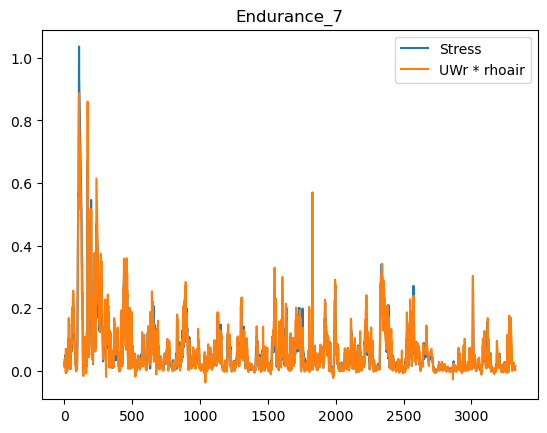

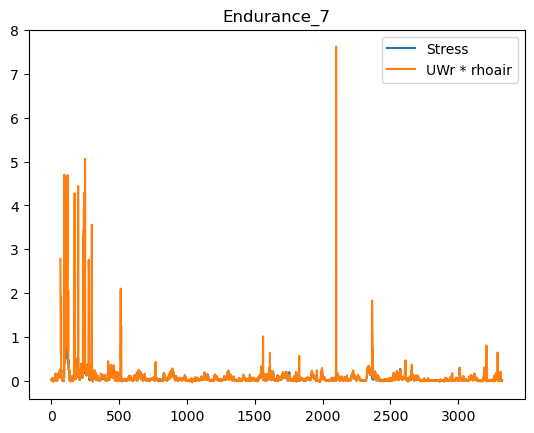

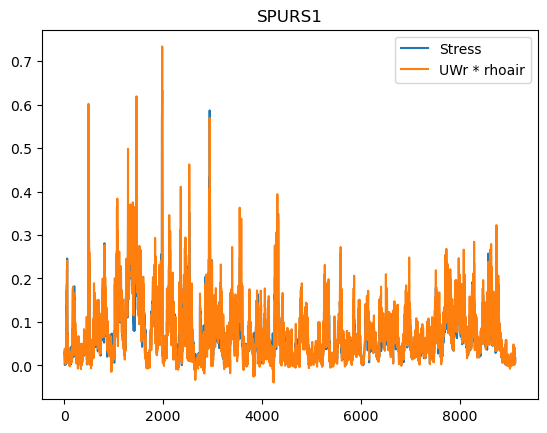

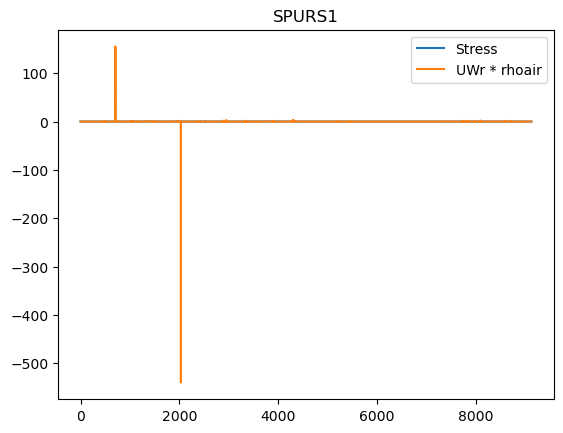

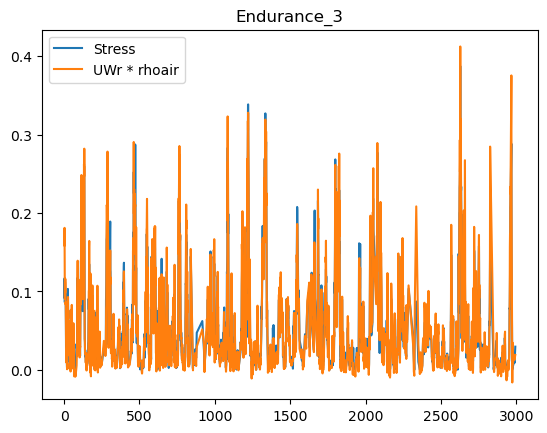

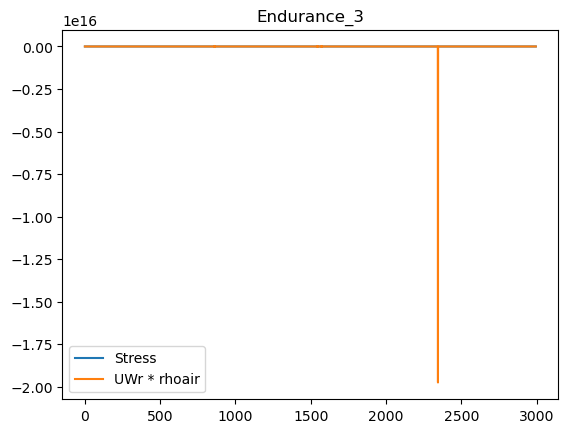

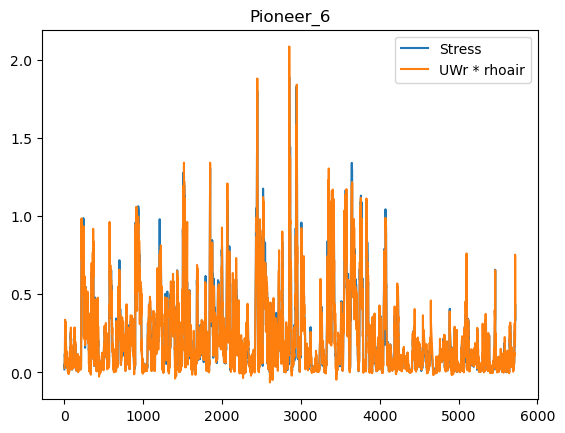

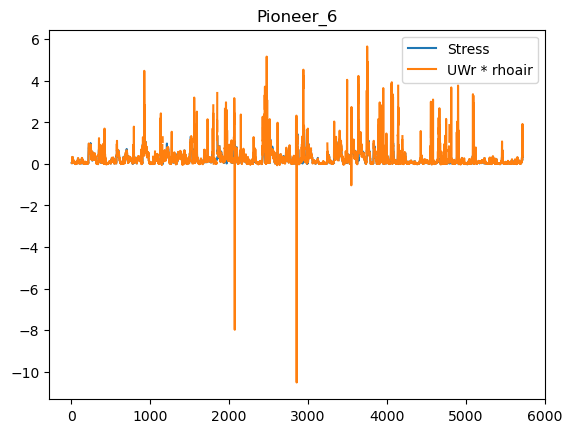

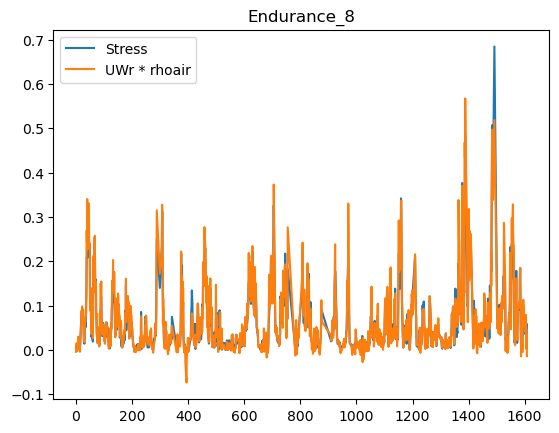

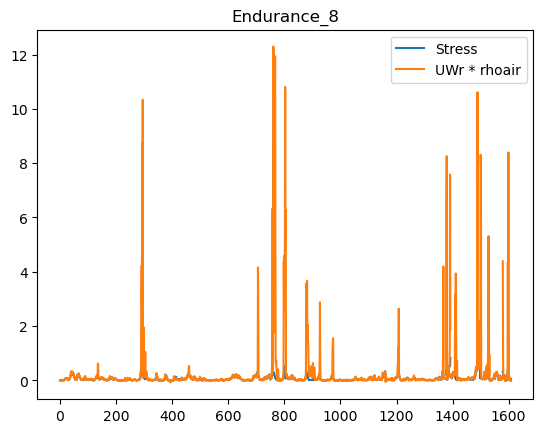

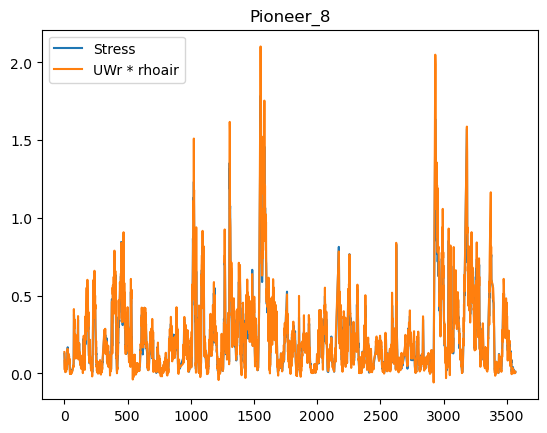

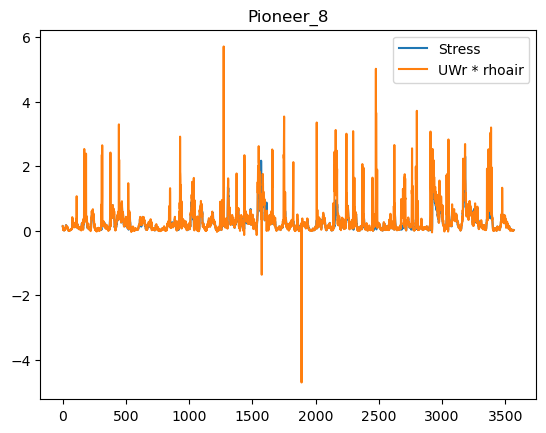

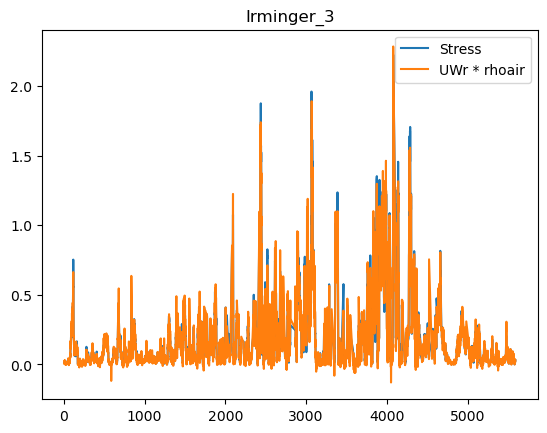

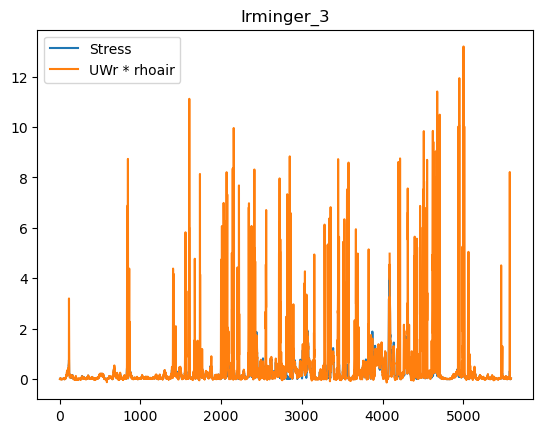

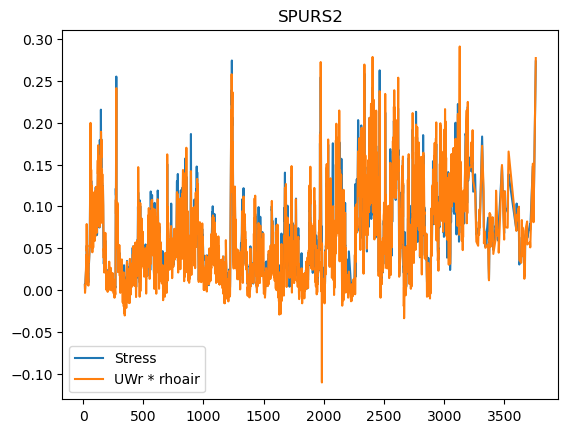

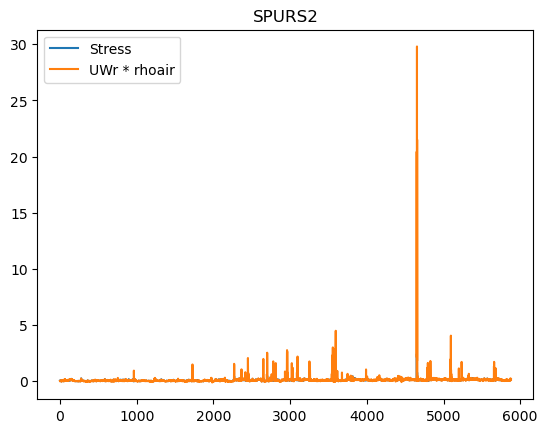

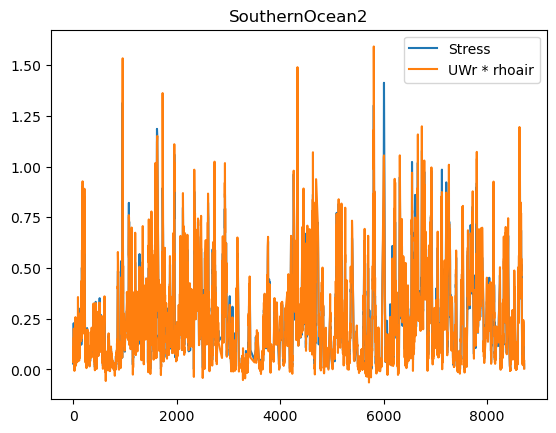

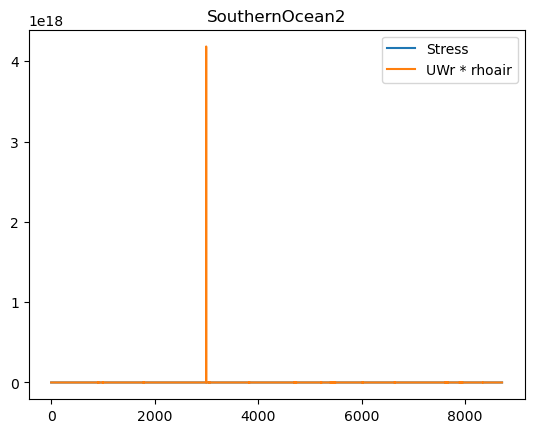

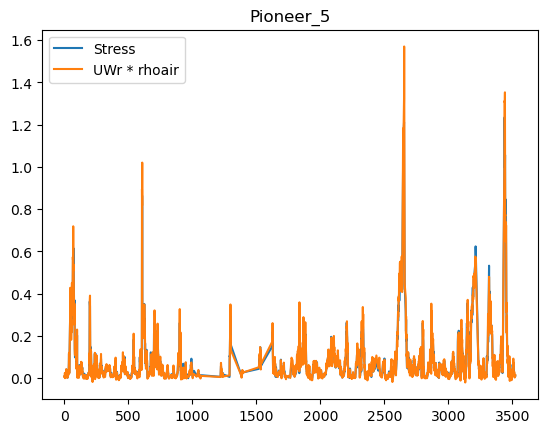

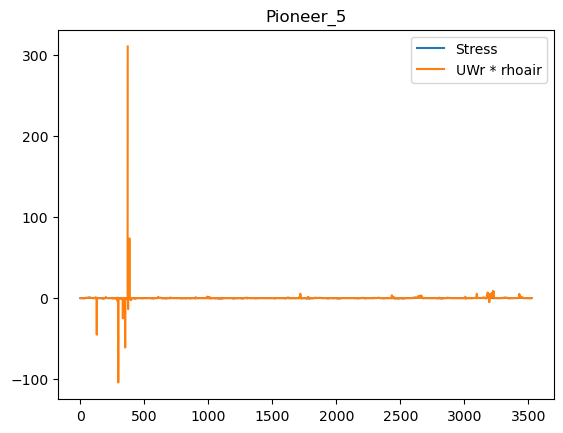

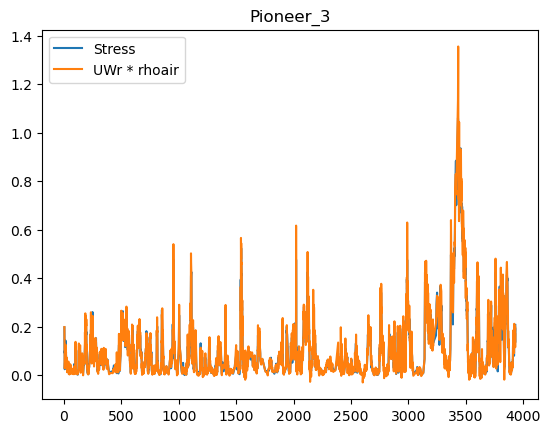

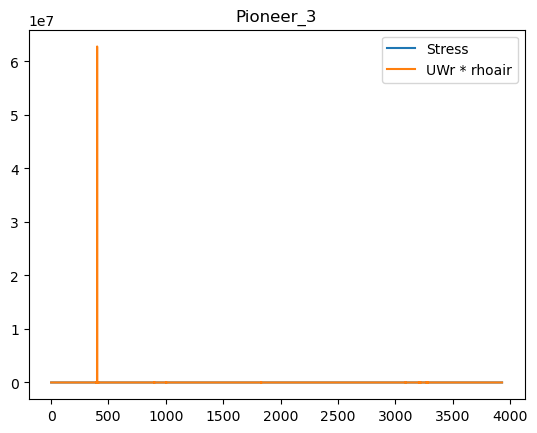

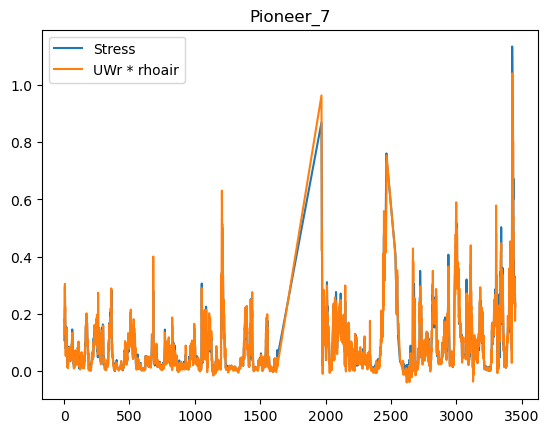

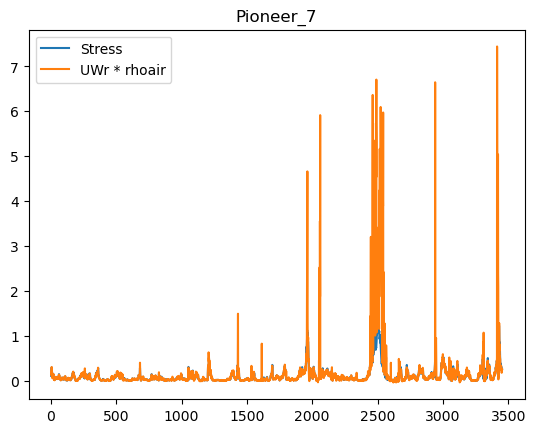

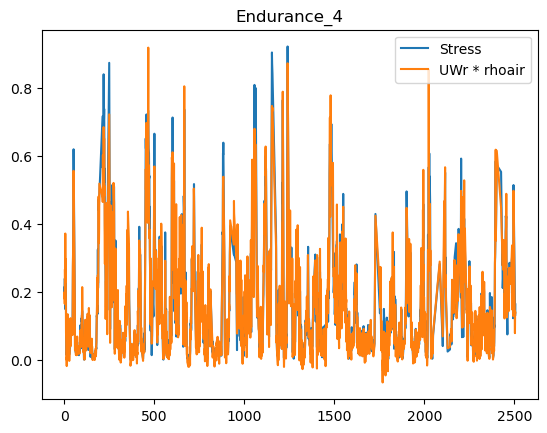

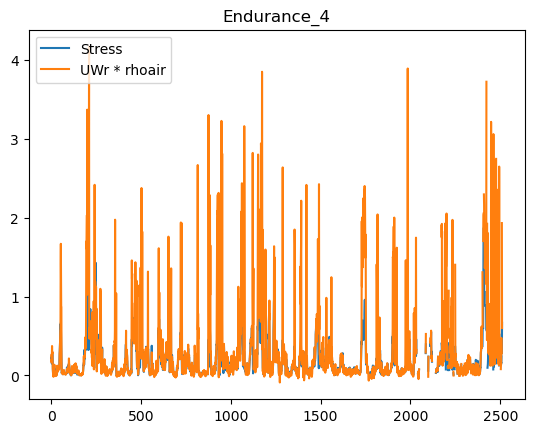

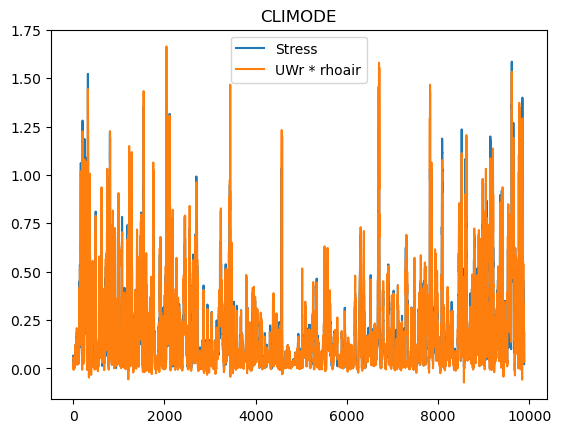

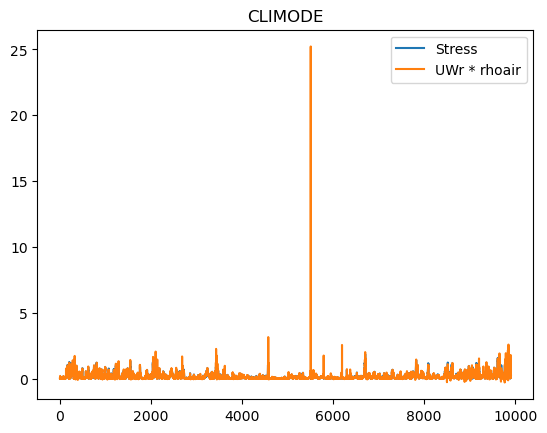

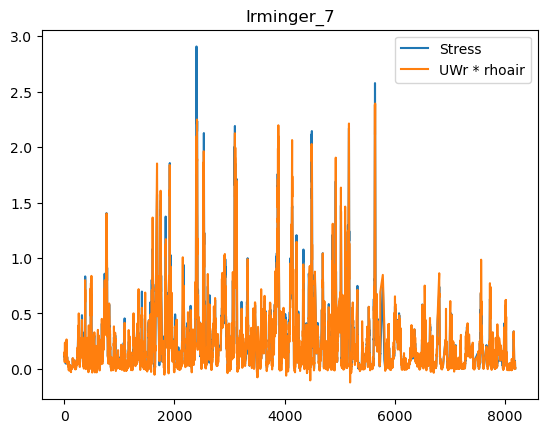

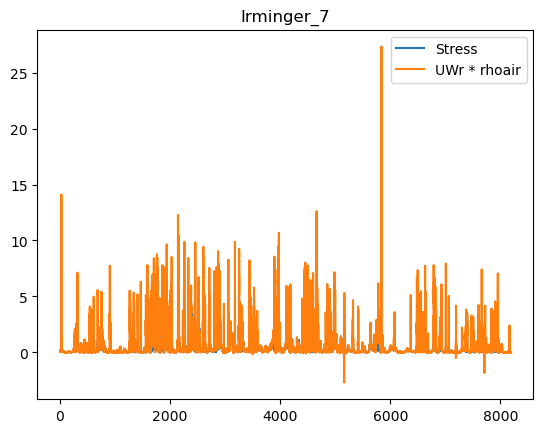

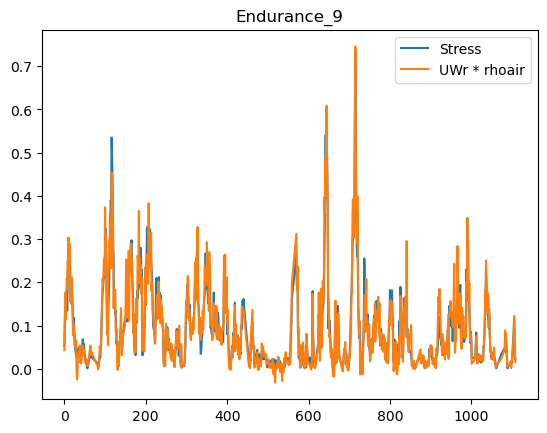

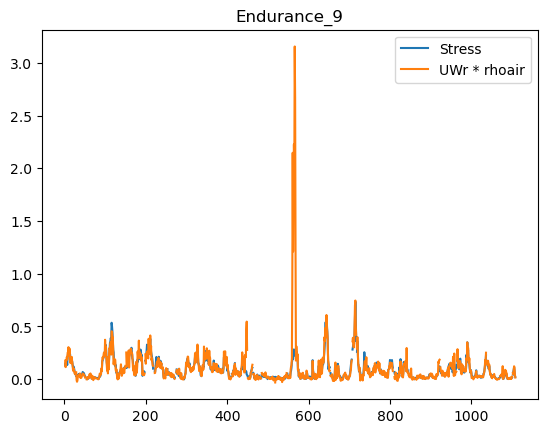

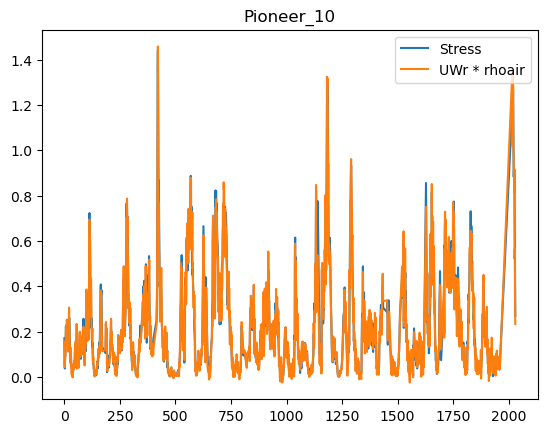

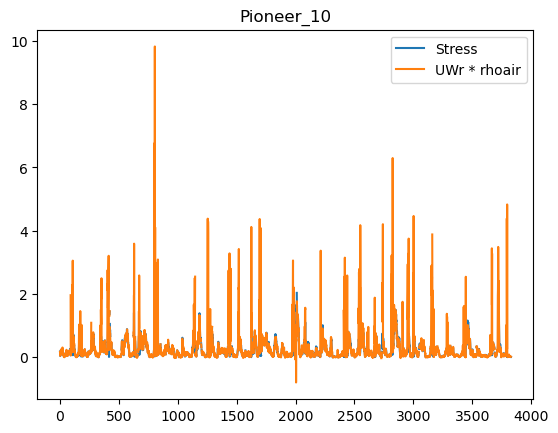

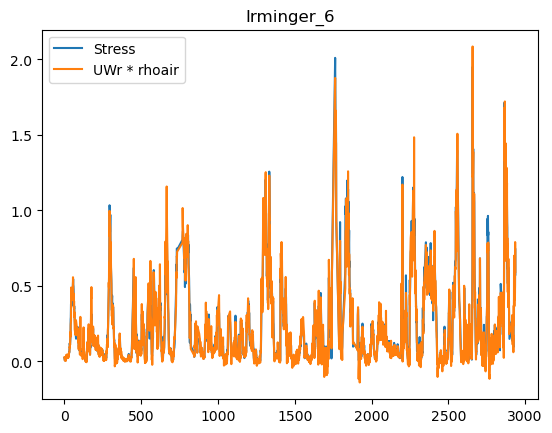

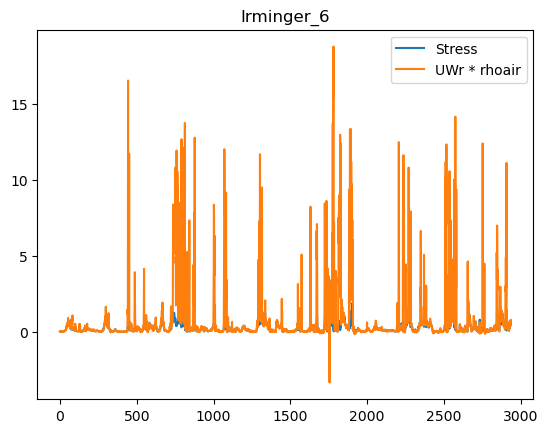

In [40]:
# for each of the datasets, do some data cleanup
# if quality flag entries for which:
# - SBytes != 0
# - any column is inf
# - any column is larger than 1e8
# - any column is close to 9999
# - UW is smaller than some given bounds
# - UW is larger than some given bounds

for crrt_dataset in dict_all_Transfer_files:
    #ic(crrt_dataset)
    time.sleep(0.5)

    crrt_pd = dict_all_Transfer_files[crrt_dataset]

    # valid rows by default
    validity_flag = np.ones((len(crrt_pd.index),), dtype=bool)

    # if find any reason why the row looks bad, invalid it
    for index, row in tqdm.tqdm(crrt_pd.iterrows(), total=len(crrt_pd.index)):

        # NOTE: here are the validity conditions; is it ok to remove the far tails?
        if \
            row["Sbytes"] != 0 or \
            (not np.all(np.isfinite((row[predictors].to_numpy().astype(np.float32))))) or \
            (np.any(row[predictors].to_numpy().astype(np.float32) > 1.0e8)) or \
            (np.any(np.abs(np.real(row[predictors].to_numpy()).astype(np.float32) - 9999.) < 1)) or \
            (row['UW'] < -2.0) or \
            (row['UW'] > 0.2) or \
            (row['UWr'] < -2.0) or \
            (row['UWr'] > 0.2):

            validity_flag[index] = 0

    # add information
    crrt_pd["valid_flag"] = validity_flag
    crrt_pd_valid = crrt_pd.loc[crrt_pd['valid_flag'] == True]
    
    path_strings = str(crrt_dataset).split('.')[0].split('_')
    if path_strings[-1].isnumeric(): 
        buoy = path_strings[-2] + '_' + path_strings[-1]
    else:
        buoy = path_strings[-1]
    print(np.sum(validity_flag), validity_flag.shape)
    plt.figure()
    plt.plot(crrt_pd_valid['stress'], label='Stress')
    plt.plot(- crrt_pd_valid['UWr'] * crrt_pd_valid['rhoair'], label='UWr * rhoair')
    plt.legend()
    plt.title(buoy)
    
    plt.figure()
    plt.plot(crrt_pd['stress'], label='Stress')
    plt.plot(- crrt_pd['UWr'] * crrt_pd['rhoair'], label='UWr * rhoair')
    plt.legend()
    plt.title(buoy)

In [12]:
crrt_dataset

PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Irminger_6.mat')

In [13]:
crrt_pd

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,sigHDir,stress,ustar,yday,yyyy,datetime,lat,lon,datetime_rounded,valid_flag
0,0.058741,0.083610,339.925002,2474.768030,1017.944242,1019.167502,7.248714,7.267303,93.933302,94.014437,...,106.608233,0.023803,0.138781,223.007639,2019,2019-08-11 00:10:59.996491,59.9337,-39.47378,2019-08-11 00:40:59.996491,True
1,0.110629,0.096598,297.949997,2475.081231,1017.797864,1019.020508,7.268667,7.284779,93.525552,93.591409,...,101.552518,0.017449,0.118826,223.049306,2019,2019-08-11 01:10:59.999656,59.9337,-39.47378,2019-08-11 01:40:59.999656,True
2,0.139019,0.126999,348.530000,2475.050118,1017.764995,1018.986008,7.469067,7.480979,93.906953,93.964349,...,98.317455,0.010006,0.089936,223.090972,2019,2019-08-11 02:11:00.000769,59.9337,-39.47378,2019-08-11 02:41:00.000769,True
3,0.187421,0.070342,337.279997,2475.037386,1017.700083,1018.920502,7.588145,7.597242,94.722052,94.793354,...,101.308285,0.006871,0.074493,223.132639,2019,2019-08-11 03:10:59.998945,59.9337,-39.47378,2019-08-11 03:40:59.998945,True
4,0.140239,0.010441,327.305002,2475.172549,1017.320471,1018.540506,7.613828,7.622443,95.132553,95.198827,...,106.933136,0.007151,0.075996,223.174306,2019,2019-08-11 04:10:59.997584,59.9337,-39.47378,2019-08-11 04:40:59.997584,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,0.078067,-0.018678,273.325001,2491.943886,997.514969,998.760501,3.100641,3.165751,80.403552,79.658724,...,204.795173,0.419266,0.576409,387.215972,2020,2020-01-22 05:10:59.952046,59.9337,-39.47378,2020-01-22 05:40:59.952046,True
2933,0.078067,-0.018678,269.544999,2491.941121,997.503489,998.747000,2.916729,2.990077,73.412752,72.353448,...,206.919255,0.409373,0.569918,387.257639,2020,2020-01-22 06:10:59.975539,59.9337,-39.47378,2020-01-22 06:40:59.975539,True
2934,0.078067,-0.018678,282.610001,2491.938347,997.989629,999.240002,3.011154,3.093219,83.999203,82.909322,...,196.948117,0.498005,0.627132,387.299306,2020,2020-01-22 07:11:00.006928,59.9337,-39.47378,2020-01-22 07:41:00.006928,True
2935,0.078067,-0.018678,258.055002,2491.916288,998.007711,999.254504,2.977888,3.049324,78.179452,77.277268,...,209.921894,0.748459,0.769358,387.340972,2020,2020-01-22 08:10:59.967979,59.9337,-39.47378,2020-01-22 08:40:59.967979,True


# Get buoy name from the dict keys

In [14]:
d = dict_all_Transfer_files

In [15]:
buoys = []
for key in d.keys():
    path_strings = str(key).split('.')[0].split('_')
    if path_strings[-1].isnumeric(): 
        buoy = path_strings[-2] + '_' + path_strings[-1]
    else:
        buoy = path_strings[-1]
    buoys.append(buoy)
buoys

['Endurance_7',
 'SPURS1',
 'Endurance_3',
 'Pioneer_6',
 'Endurance_8',
 'Pioneer_8',
 'Irminger_3',
 'SPURS2',
 'SouthernOcean2',
 'Pioneer_5',
 'Pioneer_3',
 'Pioneer_7',
 'Endurance_4',
 'CLIMODE',
 'Irminger_7',
 'Endurance_9',
 'Pioneer_10',
 'Irminger_6']

In [19]:
d[key].keys()

Index(['CE', 'CN', 'IR', 'Lv', 'P10', 'Pair', 'Q10', 'Qair', 'RH', 'RH10',
       'SSQ', 'SST', 'Sbytes', 'Solar', 'T10', 'Tair', 'Tm', 'Tp', 'Tsea',
       'Tseasonic', 'Tsonic', 'U10e', 'U10r', 'UE', 'UEr', 'UN', 'UNr', 'UW',
       'UWr', 'Ue', 'Ur', 'VW', 'VWr', 'WT', 'WTr', 'Wdir', 'Wdirr', 'cp',
       'lhf', 'moL', 'mtime', 'rain', 'rhoair', 'shf', 'sigH', 'sigHDir',
       'stress', 'ustar', 'yday', 'yyyy', 'datetime', 'lat', 'lon',
       'datetime_rounded', 'valid_flag'],
      dtype='object')

In [20]:
key

PosixPath('/lustre/storeB/project/IT/geout/machine-ocean/prepared_datasets/in_situ_data_WHOI/WHOI/Transfer_Irminger_6.mat')

In [21]:
df_in_situ = d[key]
df_in_situ

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,sigHDir,stress,ustar,yday,yyyy,datetime,lat,lon,datetime_rounded,valid_flag
0,0.058741,0.083610,339.925002,2474.768030,1017.944242,1019.167502,7.248714,7.267303,93.933302,94.014437,...,106.608233,0.023803,0.138781,223.007639,2019,2019-08-11 00:10:59.996491,59.9337,-39.47378,2019-08-11 00:40:59.996491,True
1,0.110629,0.096598,297.949997,2475.081231,1017.797864,1019.020508,7.268667,7.284779,93.525552,93.591409,...,101.552518,0.017449,0.118826,223.049306,2019,2019-08-11 01:10:59.999656,59.9337,-39.47378,2019-08-11 01:40:59.999656,True
2,0.139019,0.126999,348.530000,2475.050118,1017.764995,1018.986008,7.469067,7.480979,93.906953,93.964349,...,98.317455,0.010006,0.089936,223.090972,2019,2019-08-11 02:11:00.000769,59.9337,-39.47378,2019-08-11 02:41:00.000769,True
3,0.187421,0.070342,337.279997,2475.037386,1017.700083,1018.920502,7.588145,7.597242,94.722052,94.793354,...,101.308285,0.006871,0.074493,223.132639,2019,2019-08-11 03:10:59.998945,59.9337,-39.47378,2019-08-11 03:40:59.998945,True
4,0.140239,0.010441,327.305002,2475.172549,1017.320471,1018.540506,7.613828,7.622443,95.132553,95.198827,...,106.933136,0.007151,0.075996,223.174306,2019,2019-08-11 04:10:59.997584,59.9337,-39.47378,2019-08-11 04:40:59.997584,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2932,0.078067,-0.018678,273.325001,2491.943886,997.514969,998.760501,3.100641,3.165751,80.403552,79.658724,...,204.795173,0.419266,0.576409,387.215972,2020,2020-01-22 05:10:59.952046,59.9337,-39.47378,2020-01-22 05:40:59.952046,True
2933,0.078067,-0.018678,269.544999,2491.941121,997.503489,998.747000,2.916729,2.990077,73.412752,72.353448,...,206.919255,0.409373,0.569918,387.257639,2020,2020-01-22 06:10:59.975539,59.9337,-39.47378,2020-01-22 06:40:59.975539,True
2934,0.078067,-0.018678,282.610001,2491.938347,997.989629,999.240002,3.011154,3.093219,83.999203,82.909322,...,196.948117,0.498005,0.627132,387.299306,2020,2020-01-22 07:11:00.006928,59.9337,-39.47378,2020-01-22 07:41:00.006928,True
2935,0.078067,-0.018678,258.055002,2491.916288,998.007711,999.254504,2.977888,3.049324,78.179452,77.277268,...,209.921894,0.748459,0.769358,387.340972,2020,2020-01-22 08:10:59.967979,59.9337,-39.47378,2020-01-22 08:40:59.967979,True


In [22]:
df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
df_in_situ = df_in_situ.set_index('datetime')
df_in_situ

,CE,CN,IR,Lv,P10,Pair,Q10,Qair,RH,RH10,...,sigH,sigHDir,stress,ustar,yday,yyyy,lat,lon,datetime_rounded,valid_flag
datetime,,,,,,,,,,,,,,,,,,,,,
2019-08-11 00:10:59.996491,0.058741,0.083610,339.925002,2474.768030,1017.944242,1019.167502,7.248714,7.267303,93.933302,94.014437,...,1.21,106.608233,0.023803,0.138781,223.007639,2019,59.9337,-39.47378,2019-08-11 00:40:59.996491,True
2019-08-11 01:10:59.999656,0.110629,0.096598,297.949997,2475.081231,1017.797864,1019.020508,7.268667,7.284779,93.525552,93.591409,...,1.06,101.552518,0.017449,0.118826,223.049306,2019,59.9337,-39.47378,2019-08-11 01:40:59.999656,True
2019-08-11 02:11:00.000769,0.139019,0.126999,348.530000,2475.050118,1017.764995,1018.986008,7.469067,7.480979,93.906953,93.964349,...,1.12,98.317455,0.010006,0.089936,223.090972,2019,59.9337,-39.47378,2019-08-11 02:41:00.000769,True
2019-08-11 03:10:59.998945,0.187421,0.070342,337.279997,2475.037386,1017.700083,1018.920502,7.588145,7.597242,94.722052,94.793354,...,1.20,101.308285,0.006871,0.074493,223.132639,2019,59.9337,-39.47378,2019-08-11 03:40:59.998945,True
2019-08-11 04:10:59.997584,0.140239,0.010441,327.305002,2475.172549,1017.320471,1018.540506,7.613828,7.622443,95.132553,95.198827,...,1.02,106.933136,0.007151,0.075996,223.174306,2019,59.9337,-39.47378,2019-08-11 04:40:59.997584,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-22 05:10:59.952046,0.078067,-0.018678,273.325001,2491.943886,997.514969,998.760501,3.100641,3.165751,80.403552,79.658724,...,4.88,204.795173,0.419266,0.576409,387.215972,2020,59.9337,-39.47378,2020-01-22 05:40:59.952046,True
2020-01-22 06:10:59.975539,0.078067,-0.018678,269.544999,2491.941121,997.503489,998.747000,2.916729,2.990077,73.412752,72.353448,...,5.03,206.919255,0.409373,0.569918,387.257639,2020,59.9337,-39.47378,2020-01-22 06:40:59.975539,True
2020-01-22 07:11:00.006928,0.078067,-0.018678,282.610001,2491.938347,997.989629,999.240002,3.011154,3.093219,83.999203,82.909322,...,4.80,196.948117,0.498005,0.627132,387.299306,2020,59.9337,-39.47378,2020-01-22 07:41:00.006928,True


# Import normalized SAR data and params

In [23]:
data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

In [24]:
with open(data_dir + 'in_situ_obs_with_sar_params.pickle', 'rb') as handle:
        sar_dict = pickle.load(handle)

In [25]:
sar_dict['Endurance_8'].keys()

dict_keys(['datetime_start', 'datetime_end', 'type', 'lat', 'lon', 'nc_data_location', 'products'])

# Merge in situ obs and SAR data

empty dict for new dfs

For each key in d:

    get buoy name
    get df for that buoy
    add empty cols for s0, inc, az
    for each product
        find closest timestamp in df to (beginposition+(endposition-startposition))/2
        fill in that row with sar params
    remove rows with nans
    save df with matches in new dict


In [26]:
dt = datetime.datetime(2019, 8, 11, 0, 10, 49, 874000)
#dt + dt

In [27]:
idx = df_in_situ.index.get_indexer([dt], method='nearest')[0]
idx

0

In [28]:
timestamp = df_in_situ.index[idx]
timestamp

Timestamp('2019-08-11 00:10:59.996491')

In [29]:
buoys

['Endurance_7',
 'SPURS1',
 'Endurance_3',
 'Pioneer_6',
 'Endurance_8',
 'Pioneer_8',
 'Irminger_3',
 'SPURS2',
 'SouthernOcean2',
 'Pioneer_5',
 'Pioneer_3',
 'Pioneer_7',
 'Endurance_4',
 'CLIMODE',
 'Irminger_7',
 'Endurance_9',
 'Pioneer_10',
 'Irminger_6']

epsilon = 5e-05
count = 0
collocated_dict = {}
for key, df in d.items():
    buoy = buoys[count]
    df['s0_norm'] = np.nan
    df['s0'] = np.nan
    df['inc'] = np.nan
    df['az'] = np.nan
    df_in_situ = d[key]
    df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
    df_in_situ = df_in_situ.set_index('datetime')
    
    for product in sar_dict[buoy]['products']:
        beginposition = sar_dict[buoy]['products'][product]['beginposition']
        endposition = sar_dict[buoy]['products'][product]['endposition']
        #sar_time = (beginposition + (endposition - startposition))/2  # 
        #TypeError: unsupported operand type(s) for +: 'datetime.datetime' and 'datetime.datetime'
        
        try:
            s0 = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['s0']
            s0_norm = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['s0_norm']
            inc = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['inc']
            az = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['az']

            # Find closest timestamp
            idx = df_in_situ.index.get_indexer([beginposition], method='nearest')[0]
            timestamp = df_in_situ.index[idx]

            # Fill in data
            df_in_situ.loc[df_in_situ.index==timestamp, 's0'] = s0
            df_in_situ.loc[df_in_situ.index==timestamp, 's0_norm'] = s0_norm
            df_in_situ.loc[df_in_situ.index==timestamp, 'inc'] = inc
            df_in_situ.loc[df_in_situ.index==timestamp, 'az'] = az
            print(buoy, s0)
        except:
            df_in_situ = pd.DataFrame()
            df_in_situ['s0'] = np.nan
            #print('File ', sar_dict[buoy]['products'][product]['filename'], ' does not exist')
    df_in_situ = df_in_situ.dropna(subset=['s0'])
    collocated_dict[buoy] = df_in_situ
    print(count)             
    count = count + 1

In [30]:
epsilon = 5e-04
count = 0
collocated_dict = {}
for key, df in d.items():
    buoy = buoys[count]
    df['s0_norm'] = np.nan
    df['s0'] = np.nan
    df['inc'] = np.nan
    df['az'] = np.nan
    df_in_situ = d[key]
    df_in_situ = df_in_situ.loc[df_in_situ['valid_flag'] == True]
    df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
    df_in_situ = df_in_situ.set_index('datetime')
    
    for product in sar_dict[buoy]['products']:
        beginposition = sar_dict[buoy]['products'][product]['beginposition']
        endposition = sar_dict[buoy]['products'][product]['endposition']
        #sar_time = (beginposition + (endposition - startposition))/2  # 
        #TypeError: unsupported operand type(s) for +: 'datetime.datetime' and 'datetime.datetime'
        if str(epsilon) in sar_dict[buoy]['products'][product]['sar_params'] :
            s0 = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['s0']
            s0_norm = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['s0_norm']
            inc = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['inc']
            az = sar_dict[buoy]['products'][product]['sar_params'][str(epsilon)]['az']

            # Find closest timestamp
            idx = df_in_situ.index.get_indexer([beginposition], method='nearest')[0]
            timestamp = df_in_situ.index[idx]

            # Fill in data
            df_in_situ.loc[df_in_situ.index==timestamp, 's0'] = np.nanmean(s0)
            df_in_situ.loc[df_in_situ.index==timestamp, 's0_norm'] = np.nanmean(s0_norm)
            df_in_situ.loc[df_in_situ.index==timestamp, 'inc'] = np.nanmean(inc)
            df_in_situ.loc[df_in_situ.index==timestamp, 'az'] = np.nanmean(az)
            print(buoy, np.nanmean(s0))
            if np.nanmean(s0)==-np.inf:
                print(sar_dict[buoy]['products'][product]['filename'])
                print(np.nanmean(s0))
                print(s0)
        #else:
        #    df_in_situ = pd.DataFrame()
        #    df_in_situ['s0'] = np.nan
            #print('File ', sar_dict[buoy]['products'][product]['filename'], ' does not exist')
    
    df_in_situ = df_in_situ.replace([-np.inf], np.nan)
    df_in_situ = df_in_situ.dropna(subset=['s0'])
    collocated_dict[buoy] = df_in_situ
    print(count)             
    count = count + 1

/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Endurance_7 -21.063286
Endurance_7 -22.216413
Endurance_7 -21.339077
Endurance_7 -25.85487
Endurance_7 -26.374071
Endurance_7 -24.314722
Endurance_7 -25.329073
Endurance_7 -28.75428
Endurance_7 -18.81792
Endurance_7 -17.72778
Endurance_7 -22.867931
Endurance_7 -25.324114
Endurance_7 -18.858349
Endurance_7 -21.884426
Endurance_7 -15.513192
Endurance_7 -22.038048
Endurance_7 -14.30343
Endurance_7 -19.869596
Endurance_7 -23.493656
Endurance_7 -16.396244
Endurance_7 -20.533834
Endurance_7 -19.869596
Endurance_7 -20.528923
Endurance_7 -21.946009
Endurance_7 -16.376326
Endurance_7 -16.2119
Endurance_7 -15.423333
Endurance_7 -11.019015
0
1
Endurance_3 -24.617025
Endurance_3 -20.701244
Endurance_3 -24.44478
Endurance_3 -19.07718
Endurance_3 -26.001904
Endurance_3 -19.006102
Endurance_3 -24.121826
Endurance_3 -15.626734
Endurance_3 -23.725256
Endurance_3 -19.326546
2
Pioneer_6 -8.744681
Pioneer_6 -22.633314
Pioneer_6 -20.283642
Pioneer_6 -15.981173
Pioneer_6 -19.310995
Pioneer_6 -13.40085
Pione

/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])


Irminger_3 -10.888052756445793
Irminger_3 -7.994932112705508
Irminger_3 -9.831746383752378
Irminger_3 -7.982015702876789
Irminger_3 -inf
S1B_EW_GRDH_1SDH_20170313T202720_20170313T202820_004695_008319_6583.SAFE
-inf
[[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
Irminger_3 -inf
S1B_EW_GRDM_1SDH_20170313T202720_20170313T202820_004695_008319_C624.SAFE
-inf
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]]
Irminger_3 -2.8782742304982674
Irminger_3 -inf
S1B_EW_GRDM_1SDH_20170310T084725_20170310T084825_004644_008191_E76F.SAFE
-inf
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]]
Irminger_3 -8.14208913506566
Irminger_3 -21.85209916815408
Irminger_3 -23.498594645664998
Irminger_3 -19.4590379905036
Irminger_3 -3.3046346556174364
Irminger_3 -8.23020920120444
Irminger_3 -14.867913160533826
Irminger_3 -17.019471654328175
Irminger_3 -14.019519246778534
Irminger_3 -inf
S1B_EW_GRDH_1SDH_20170301T202720_20170301T202820_004520_007DEB_C49A.SAFE
-inf
[[-inf -inf -inf]
 [-inf -inf

/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

7
8
Pioneer_5 -19.620932
Pioneer_5 -23.804827
Pioneer_5 -7.9776754
Pioneer_5 -16.246105
Pioneer_5 -25.811707
Pioneer_5 -22.66827
9
Pioneer_3 -13.130713
Pioneer_3 -10.948495
Pioneer_3 -14.444214
Pioneer_3 -16.513123
Pioneer_3 -18.18081
Pioneer_3 -17.616224
Pioneer_3 -17.213701
Pioneer_3 -14.577395
Pioneer_3 -18.83224
Pioneer_3 -21.736687
10
Pioneer_7 -29.06027
Pioneer_7 -26.754469
Pioneer_7 -22.093863
Pioneer_7 -16.69411
Pioneer_7 -15.379298
Pioneer_7 -24.145607
Pioneer_7 -21.263481
Pioneer_7 -16.625086
Pioneer_7 -26.397457
Pioneer_7 -18.085205
Pioneer_7 -15.889144
Pioneer_7 -23.02698
Pioneer_7 -18.854748
Pioneer_7 -17.952158
Pioneer_7 -21.165356
Pioneer_7 -15.080737
11
Endurance_4 -11.554965
Endurance_4 -16.304699
Endurance_4 -15.87524
Endurance_4 -16.103523
Endurance_4 -20.8236
Endurance_4 -12.773283
Endurance_4 -16.336338
Endurance_4 -20.274115
Endurance_4 -16.30482
Endurance_4 -22.335732
Endurance_4 -13.069661
Endurance_4 -16.25751
Endurance_4 -12.873801
Endurance_4 -18.541004
Endur

/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_situ['datetime'] = pd.to_datetime(df_in_situ['datetime'])
/tmp/ipykernel_3859204/105461338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Irminger_6 -8.587727054136982
Irminger_6 -7.864874035318754
Irminger_6 -10.46582259535228
Irminger_6 -19.914491734780448
Irminger_6 -10.488730270944046
Irminger_6 -inf
S1B_EW_GRDH_1SDH_20191110T202740_20191110T202840_018870_02396C_01A4.SAFE
-inf
[[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
Irminger_6 -inf
S1B_EW_GRDM_1SDH_20191110T202740_20191110T202840_018870_02396C_4E3F.SAFE
-inf
[[-inf -inf]
 [-inf -inf]
 [-inf -inf]]
Irminger_6 -8.817403403193259
Irminger_6 -11.598601873258565
Irminger_6 -16.42823704605765
Irminger_6 -15.321923522996434
Irminger_6 -11.581957460017762
Irminger_6 -8.58683539315338
Irminger_6 -12.497279903850867
Irminger_6 -20.34333851026659
Irminger_6 -23.915643082173165
Irminger_6 -inf
S1B_EW_GRDH_1SDH_20191029T202740_20191029T202840_018695_0233C8_62BB.SAFE
-inf
[[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
Irminger_6 -inf
S1B_EW_GRDM_1SDH_20191029T202740_20191029T202840_01869

In [31]:
collocated_dict['Pioneer_7'][['UWr', 'rhoair', 's0']].index.get_indexer([datetime.datetime(2017, 10, 22, 22, 42, 24, 875000)], method='nearest')

array([15])

In [32]:
collocated_dict['Pioneer_7'][['UWr', 'rhoair', 's0']]

,UWr,rhoair,s0
datetime,,,
2017-06-12 11:10:59.967536,-0.042344,1.212813,-15.080737
2017-06-12 23:10:59.983629,-0.036690,1.213003,-21.165356
2017-06-24 23:10:59.998837,-0.041088,1.192970,-17.952158
2017-07-06 11:10:59.995377,-0.019187,1.203083,-18.854748
2017-07-18 23:10:59.995096,-0.015328,1.179373,-23.026979
2017-07-30 11:11:00.010425,-0.094400,1.197105,-15.889144
2017-07-30 23:11:00.001312,-0.066846,1.201028,-18.085205
2017-08-12 00:11:00.042547,-0.001697,1.192977,-26.397457
2017-08-16 14:10:59.978429,-0.015690,1.183057,-16.625086


In [33]:
collocated_dict['Irminger_3'][['UWr', 'rhoair', 's0']]

,UWr,rhoair,s0
datetime,,,
2016-07-12 09:10:59.978919,-0.009191,1.253068,-21.923150
2016-07-12 20:10:59.999230,-0.000924,1.255386,-17.854439
2016-07-17 09:10:59.980719,-0.054515,1.241977,-16.119089
2016-07-17 20:10:59.974647,-0.017296,1.244527,-23.556729
2016-07-19 20:10:59.998415,0.014171,1.252602,-23.661248
...,...,...,...
2017-08-06 20:11:59.980830,-0.011672,1.258144,-17.736610
2017-08-07 20:12:00.001057,-0.054866,1.252131,-8.296983
2017-08-11 09:11:59.999535,-0.041067,1.247842,-15.598502


with open(data_dir + 'collocated_dict_5e_4_filtered.pickle', 'wb') as handle:
    pickle.dump(collocated_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
sar_dict['Pioneer_7']['products']['7e1d1641-af53-4486-bb45-8411c61d1aba']['sar_params']['5e-05'].keys()

dict_keys(['epsilon', 's0', 's0_norm', 'inc', 'az', 'grid_lons', 'grid_lats', 'pol'])

In [36]:
collocated_dict['Irminger_7']['s0'].shape

(255,)